In [ ]:
"""
 ## Deal Closure Prediction Using Machine Learning

Develop and compare multiple machine learning models to predict deal outcomes (Won/Lost) using sales activity data to maximize prediction accuracy.
1. Data Analysis & Preprocessing
2. Model Development
3. Model Evaluation
4. Innovation & Optimization

"""

In [ ]:
!pip install xgboost

In [ ]:
pip install lightgbm

## Importing required libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier, plot_importance

import lightgbm as lgb

from sklearn.ensemble import StackingClassifier

## Reading data from CSV to DataFrame

In [5]:
# ==========  1. LOADING SAMPLE DATA =================
data = pd.read_csv("C:/Users/wankh/Desktop/SPRINGER CAPITAL/GLYNAC ON BOARDING/Glynac Projects/Glynac Projects by ME/ANASIS-36/deal_details.csv")
data.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage
0,92535648,0,0,0,0,0,0,547305.0,2022-02-23T00:49:22.065Z,newbusiness,Closed Won
1,92535649,0,0,0,0,0,0,176160.0,2022-02-23T00:45:38.840Z,NaN,Closed Won
2,92535650,0,0,0,0,0,0,4000.0,2022-03-16T23:48:11.625Z,newbusiness,Closed Won
3,92535651,159,0,10,4,2,0,40000.0,2024-04-04T15:59:24.039Z,newbusiness,Closed Won
4,92535652,0,0,0,0,0,0,4000.0,2022-05-31T23:40:49.208Z,newbusiness,Closed Won


## Total number of records present

In [6]:
data.shape

(309, 11)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    309 non-null    int64  
 1   email_count           309 non-null    int64  
 2   call_count            309 non-null    int64  
 3   task_count            309 non-null    int64  
 4   meeting_count         309 non-null    int64  
 5   notes_count           309 non-null    int64  
 6   conversation_count    309 non-null    int64  
 7   deal_size             305 non-null    float64
 8   properties.closedate  219 non-null    object 
 9   properties.dealtype   295 non-null    object 
 10  deal_stage            309 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 26.7+ KB


##  ================   1. DATA ANALYSIS & PREPROCESSING ===============

### 1.1 Converting Date to DateTime Fomat

In [8]:
# ================= 2. CONVERTING DATA TO datetime ==================
data['properties.closedate'] = pd.to_datetime(data['properties.closedate'], errors = 'coerce')

### 1.2 Checking for Missing Values

In [9]:
# =========== 3. CHECKING MISSING VALUES ===============
data.isnull().sum()

id                       0
email_count              0
call_count               0
task_count               0
meeting_count            0
notes_count              0
conversation_count       0
deal_size                4
properties.closedate    90
properties.dealtype     14
deal_stage               0
dtype: int64

### 1.2  Handling missing values for 'deal_size'

In [10]:
# ================ 4. HANDLING MISSING VALUES =================
""" There are a few entries(4) in deal_size, so we can remove those rows 
but before removing take a look at the dataset to decide whether it is safe to remove these values or not.
After close observation it looks safe to remove those 4 entries. But on other side, we could replace it with median."""

data_cleaned = data.dropna(subset = ['deal_size'])

### 1.3 Handling missing values for 'properties.dealtype'

In [11]:
# ============== 4. HANDLING MISSING VALUES =================
"""
Only 14 missing so we can do one of the following:

- Fill with most common value (newbusiness) [ safe and quick ]

- Or create a new category called unknown

Filling with "newbusiness", since that is most common in the dataset

"""
#  Fill missing dealtype with "newbusiness"
data_cleaned.loc[:, 'properties.dealtype'] = data_cleaned['properties.dealtype'].fillna('newbusiness')


### 1.4   FEATURE ENGINEEING: Creating a new feature where 'closedate' is available to find number of days took for closing the deal

In [ ]:
# ============== 4. HANDLING MISSING VALUES =================
"""
There are lot of missing values in 'properties.closedate'. 
We’ll create a new feature only for rows that have this date, like days_to_close.

But For now, we keep rows with missing close date in the dataset for training models 
(just exclude date-based features)

We need to make both datetime objects either timezone-aware or timezone-naive. 
Let's make both timezone-naive for simplicity by removing the timezone information.
"""

#  Convert to datetime, then remove timezone safely before assigning
closedate_converted = pd.to_datetime(data_cleaned['properties.closedate'], errors='coerce')

# Only localize rows that have timezone awareness
if closedate_converted.dt.tz is not None:
    closedate_converted = closedate_converted.dt.tz_localize(None)

# Assign cleaned datetime back to the DataFrame
data_cleaned.loc[:, 'properties.closedate'] = closedate_converted


# Creating a datetime object for today (timezone-naive)
today = pd.to_datetime('today')

#  Create new feature: days_to_close only where closedate is available
data_cleaned.loc[:, 'days_to_close'] = ( data_cleaned['properties.closedate'] - today ).dt.days;

#  mark if closedate is missing/ Add a binary flag for whether closedate exists
data_cleaned.loc[:, 'has_closedate'] = data_cleaned['properties.closedate'].notnull().astype(int);


In [13]:
data_cleaned.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage,days_to_close,has_closedate
0,92535648,0,0,0,0,0,0,547305.0,2022-02-23 00:49:22.065,newbusiness,Closed Won,-1200.0,1
1,92535649,0,0,0,0,0,0,176160.0,2022-02-23 00:45:38.840,newbusiness,Closed Won,-1200.0,1
2,92535650,0,0,0,0,0,0,4000.0,2022-03-16 23:48:11.625,newbusiness,Closed Won,-1178.0,1
3,92535651,159,0,10,4,2,0,40000.0,2024-04-04 15:59:24.039,newbusiness,Closed Won,-429.0,1
4,92535652,0,0,0,0,0,0,4000.0,2022-05-31 23:40:49.208,newbusiness,Closed Won,-1102.0,1


In [14]:
# =========== CHECKING MISSING VALUES ===============
data_cleaned.isnull().sum()

id                       0
email_count              0
call_count               0
task_count               0
meeting_count            0
notes_count              0
conversation_count       0
deal_size                0
properties.closedate    90
properties.dealtype      0
deal_stage               0
days_to_close           90
has_closedate            0
dtype: int64

In [15]:
data_cleaned.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage,days_to_close,has_closedate
0,92535648,0,0,0,0,0,0,547305.0,2022-02-23 00:49:22.065,newbusiness,Closed Won,-1200.0,1
1,92535649,0,0,0,0,0,0,176160.0,2022-02-23 00:45:38.840,newbusiness,Closed Won,-1200.0,1
2,92535650,0,0,0,0,0,0,4000.0,2022-03-16 23:48:11.625,newbusiness,Closed Won,-1178.0,1
3,92535651,159,0,10,4,2,0,40000.0,2024-04-04 15:59:24.039,newbusiness,Closed Won,-429.0,1
4,92535652,0,0,0,0,0,0,4000.0,2022-05-31 23:40:49.208,newbusiness,Closed Won,-1102.0,1


### 1.5 FEATURE ENGINEEING: Creating
1. 'total_activities' = sum of all activities (emails, calls, tasks, meetings, notes, conversations)
2. 'time_until_close' = number of days between today and properties.closedate
3. 'activity_to_size_ratio' = total_activities / deal_size

In [ ]:
# 1. Create total_activities column
activity_cols = ['email_count', 'call_count', 'task_count', 'meeting_count', 'notes_count', 'conversation_count']
data_cleaned.loc[:, 'total_activities'] = data_cleaned[activity_cols].sum(axis=1)

# 2. Copy days_to_close into time_until_close
data_cleaned.loc[:, 'time_until_close'] = data_cleaned['days_to_close']

# 3. Create activity_to_size_ratio safely
data_cleaned.loc[:, 'activity_to_size_ratio'] = data_cleaned.apply(
    lambda row: row['total_activities'] / row['deal_size'] if row['deal_size'] and row['deal_size'] != 0 else 0,
    axis=1
);

# Replace any inf or NaN just in case
data_cleaned.loc[:, 'activity_to_size_ratio'] =
    data_cleaned['activity_to_size_ratio']
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0);



In [ ]:
"""
# ============ADDITIONAL FEATURES===========
# 4. Creating Deal Size Bins (e.g., small, medium, large)
def bin_deal_size(amount):
    if amount < 1000:
        return 'small'
    elif amount < 10000:
        return 'medium'
    else:
        return 'large'

data_cleaned.loc[:, 'deal_size_bin'] = (data_cleaned['deal_size'].apply(bin_deal_size));

# 5. Communication Density (emails + calls per day)
# How frequently the rep is engaging per unit of deal lifetime?

data_cleaned.loc[:, 'communication_count'] = data_cleaned['email_count'] + data_cleaned['call_count']
data_cleaned.loc[:, 'communication_density'] = data_cleaned['communication_count'] / (data_cleaned['days_to_close'] + 1);
"""

In [18]:
data_cleaned.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage,days_to_close,has_closedate,total_activities,time_until_close,activity_to_size_ratio
0,92535648,0,0,0,0,0,0,547305.0,2022-02-23 00:49:22.065,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000
1,92535649,0,0,0,0,0,0,176160.0,2022-02-23 00:45:38.840,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000
2,92535650,0,0,0,0,0,0,4000.0,2022-03-16 23:48:11.625,newbusiness,Closed Won,-1178.0,1,0,-1178.0,0.000000
3,92535651,159,0,10,4,2,0,40000.0,2024-04-04 15:59:24.039,newbusiness,Closed Won,-429.0,1,175,-429.0,0.004375
4,92535652,0,0,0,0,0,0,4000.0,2022-05-31 23:40:49.208,newbusiness,Closed Won,-1102.0,1,0,-1102.0,0.000000


## Dataset Back-up

In [19]:

data_cleaned = data_cleaned.fillna(0)

new_data = data_cleaned.copy()
data_cleaned_original = data_cleaned.copy()

 

### 1.6 Visualizing Outliers using Boxplots : BEFORE OUTLIER DETECTION

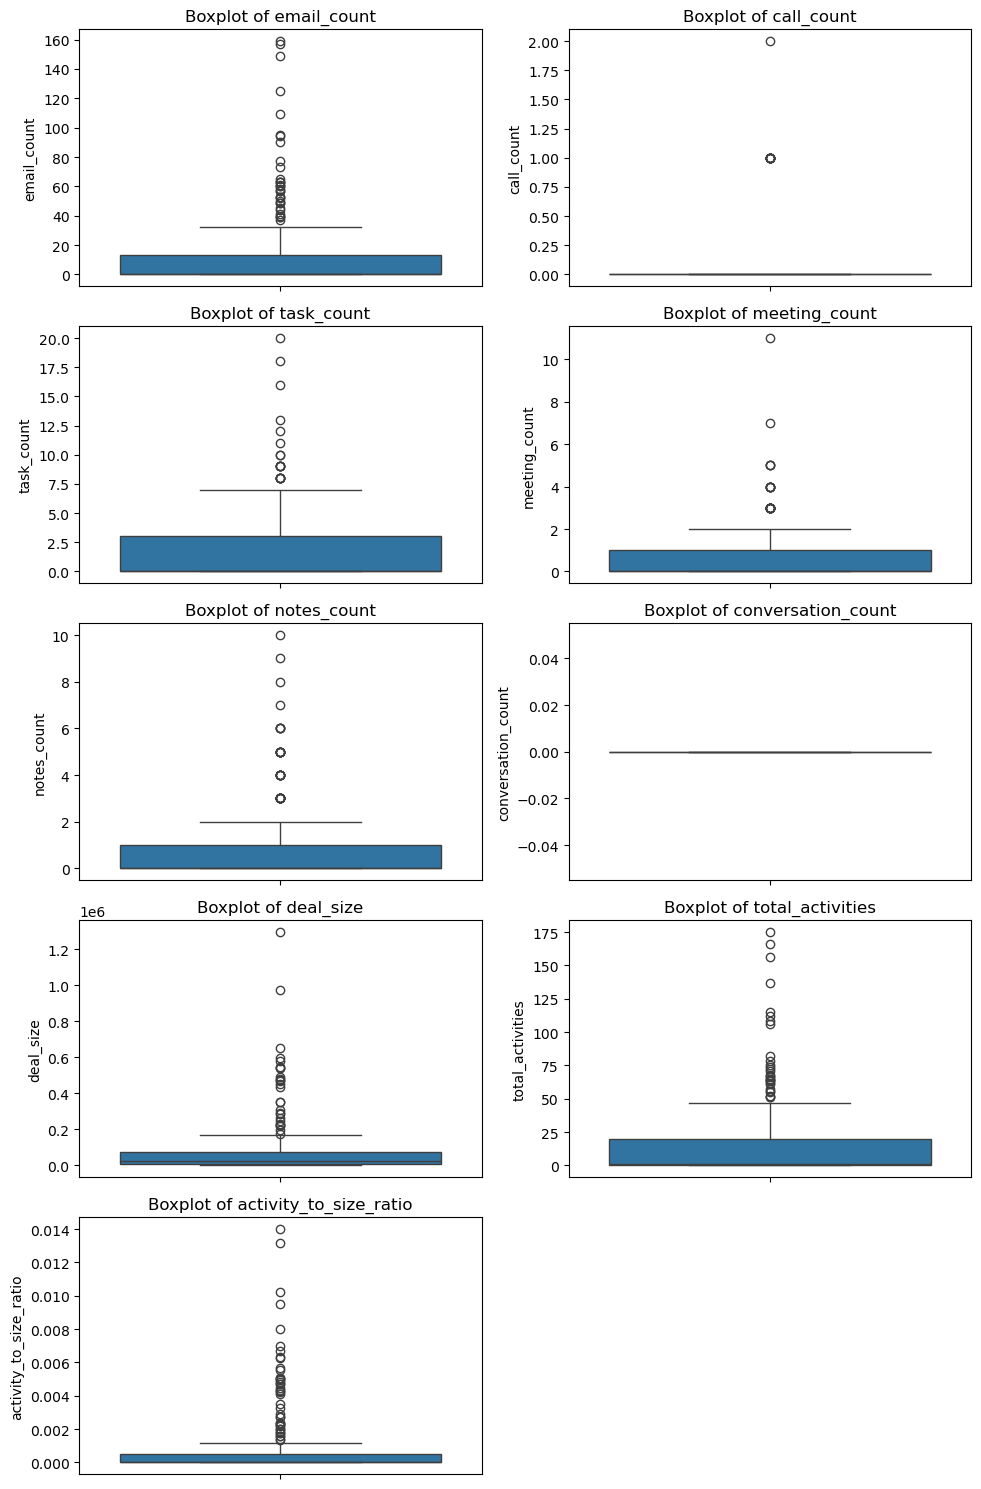

In [20]:
# List of numerical columns to check
num_cols = [
    'email_count', 'call_count', 'task_count', 'meeting_count',
    'notes_count', 'conversation_count', 'deal_size',
    'total_activities', 'activity_to_size_ratio'
]

# Plot boxplots
plt.figure(figsize=(10, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


### 1.7 Handle Outliers Using IQR Method

In [ ]:
"""
Replace outliers with boundary values (winsorization): 
so that extreme outliers won’t skew our model or visualizations.
"""

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
     # Ensure data is float before assigning
    df.loc[:, column] = df[column].astype(float).clip(lower, upper);

# Apply to all numeric columns
for col in num_cols:
    handle_outliers(data_cleaned, col);


In [22]:
print(data_cleaned[num_cols].describe())

       email_count  call_count  task_count  meeting_count  notes_count  \
count   305.000000       305.0  305.000000     305.000000   305.000000   
mean      7.506557         0.0    1.575410       0.481967     0.614754   
std      11.561476         0.0    2.462726       0.850021     0.922995   
min       0.000000         0.0    0.000000       0.000000     0.000000   
25%       0.000000         0.0    0.000000       0.000000     0.000000   
50%       0.000000         0.0    0.000000       0.000000     0.000000   
75%      13.000000         0.0    3.000000       1.000000     1.000000   
max      32.500000         0.0    7.500000       2.500000     2.500000   

       conversation_count      deal_size  total_activities  \
count               305.0     305.000000        305.000000   
mean                  0.0   50371.077377         11.701639   
std                   0.0   54289.284227         16.933680   
min                   0.0       0.000000          0.000000   
25%                   0

### 1.8 Visualizing Boxplots AFTER HANDLING OUTLIER 

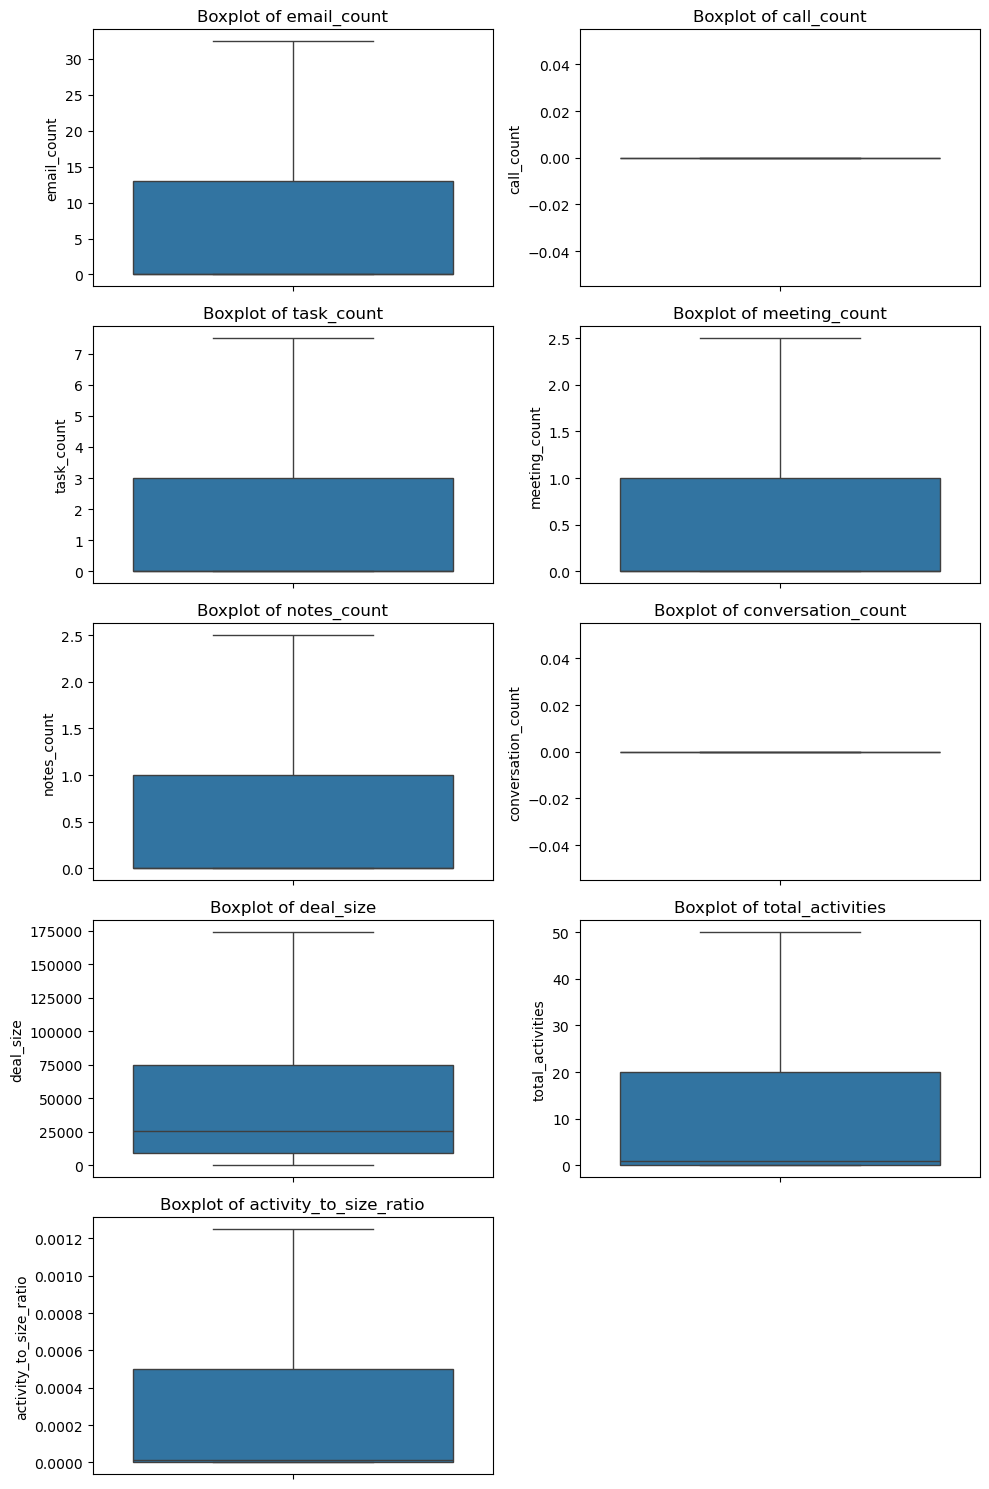

In [23]:
# Plot boxplots
plt.figure(figsize=(10, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### What to look for in Outliers:

Are outliers just a few points?

Are they way too far from the rest?

Do they happen in only one deal stage (e.g., only Closed Won)?


### 1.9 Checking Outliers for specific columns : Deal Size

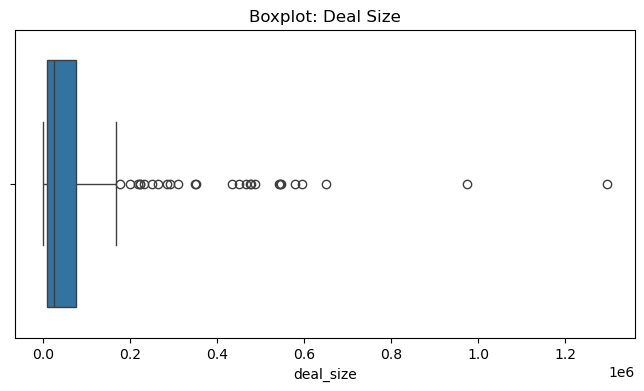

In [24]:
# Boxplot for deal_size
plt.figure(figsize=(8, 4))
sns.boxplot(x=new_data['deal_size'])
plt.title("Boxplot: Deal Size")
plt.show()

### 1.10  Flag Outliers (Don’t Remove Yet)
###  Instead of removing them, just create a new column ( is_outlier_deal ) to check whether the deal size is outlier or not

In [25]:

# Mark outliers in 'deal_size'
Q1 = new_data['deal_size'].quantile(0.25)
Q3 = new_data['deal_size'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

new_data['is_outlier_deal'] = (
    (new_data['deal_size'] < lower) | (new_data['deal_size'] > upper)
).astype(int)


In [26]:
new_data.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage,days_to_close,has_closedate,total_activities,time_until_close,activity_to_size_ratio,is_outlier_deal
0,92535648,0,0,0,0,0,0,547305.0,2022-02-23 00:49:22.065000,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000,1
1,92535649,0,0,0,0,0,0,176160.0,2022-02-23 00:45:38.840000,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000,1
2,92535650,0,0,0,0,0,0,4000.0,2022-03-16 23:48:11.625000,newbusiness,Closed Won,-1178.0,1,0,-1178.0,0.000000,0
3,92535651,159,0,10,4,2,0,40000.0,2024-04-04 15:59:24.039000,newbusiness,Closed Won,-429.0,1,175,-429.0,0.004375,0
4,92535652,0,0,0,0,0,0,4000.0,2022-05-31 23:40:49.208000,newbusiness,Closed Won,-1102.0,1,0,-1102.0,0.000000,0


### 1.11 Compare average total activities for outliers vs non-outliers

In [27]:

new_data.groupby('is_outlier_deal')['total_activities'].mean()


is_outlier_deal
0    15.035971
1    13.629630
Name: total_activities, dtype: float64

### 1.12 Interpretation of the result:
Outlier deals (in terms of deal_size) actually had fewer total activities on average than normal deals.

So these outliers were not driven by extra effort or engagement (calls, emails, meetings, etc.).

1. If these outlier deals are big in size but required fewer activities:

    - They may be strategic deals (e.g., negotiated at executive level).

    - They might be inbound leads that were easier to close.

    - Or it could indicate data entry errors

2. If outlier deals are small but still flagged, check:

    - Are they quick wins with high ROI?

    - Or junk leads that didn’t qualify?

### Analyze Their Business Meaning
1. Ask:

    - Are these large deals mostly Closed Won or Closed Lost?

    - Do they come from new vs existing customers?

    - Are they associated with higher activity?

2. Use Separate Models
    When building ML models later, try training:

    - One model with outliers

    - Another model without outliers

    Then compare their accuracy or AUC.

### Diving Deeper into Outlier Analysis

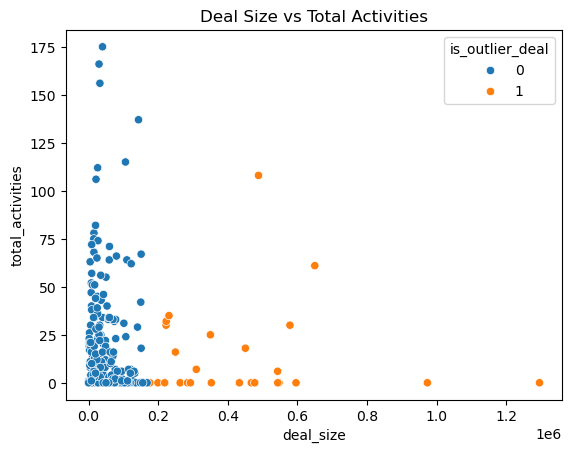

In [28]:
# ============ LET'S DIVE DEEPER =================
# 1. Check how outliers are distributed across stages:
new_data.groupby(['is_outlier_deal', 'deal_stage']).size()

# 2. Plot a scatterplot:
sns.scatterplot(data = new_data, x='deal_size', y='total_activities', hue='is_outlier_deal')
plt.title('Deal Size vs Total Activities')
plt.show()


In [29]:
# 3. Compare success rate:
# Assuming you have 'deal_status' or similar binary column for win/loss
new_data.groupby('is_outlier_deal')['deal_stage'].value_counts(normalize=True)


is_outlier_deal  deal_stage 
0                Closed lost    0.812950
                 Closed Won     0.187050
1                Closed lost    0.814815
                 Closed Won     0.185185
Name: proportion, dtype: float64

### Interpretation of the above result:
The result shows the proportion of deals won vs. lost in both normal and outlier deals.

Outliers and normal deals have nearly identical win/loss ratios.

Both lose ~81% of the time and win ~19%.

So, outlier deals aren't performing better or worse in terms of closure.

In [30]:
# === Segment by Deal Type: ===
new_data.groupby(['is_outlier_deal', 'properties.dealtype'])['deal_size'].describe()


count           mean            std  \
is_outlier_deal properties.dealtype                                        
0               existingbusiness      22.0   40885.363636   33907.639574   
                newbusiness          256.0   38147.267969   40532.751553   
1               existingbusiness       1.0  543620.000000            NaN   
                newbusiness           26.0  436515.210385  252435.859441   

                                          min        25%       50%       75%  \
is_outlier_deal properties.dealtype                                            
0               existingbusiness       8500.0   17872.50   25675.0   57125.0   
                newbusiness               0.0    8475.00   20850.0   53925.0   
1               existingbusiness     543620.0  543620.00  543620.0  543620.0   
                newbusiness          176160.0  252909.75  393021.5  529447.5   

                                           max  
is_outlier_deal properties.dealtype             
0               existingbusiness      120758.0  
                newbusiness           168100.0  
1               existingbusiness      543620.0  
                newbusiness          1295650.0

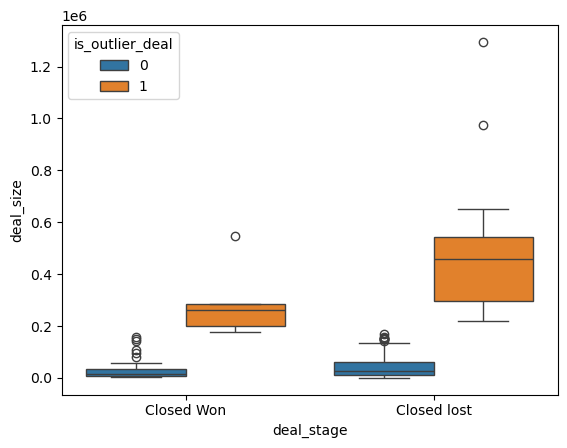

In [31]:
# === Plot distribution with win/loss: ===
sns.boxplot(data = new_data, x='deal_stage', y='deal_size', hue='is_outlier_deal');


### Interpretation: 
Outlier deals are significantly larger, especially in new business.
That could mean:

High-stakes opportunities (VIP clients, enterprise deals).

Custom contracts or multi-year agreements.

Potential reporting/input errors if values are too inflated.

'\n"We draw a picture that compares how big normal and extra-big (outlier) deals are for each type of deal.\nIt helps us see the difference with our eyes."\n'

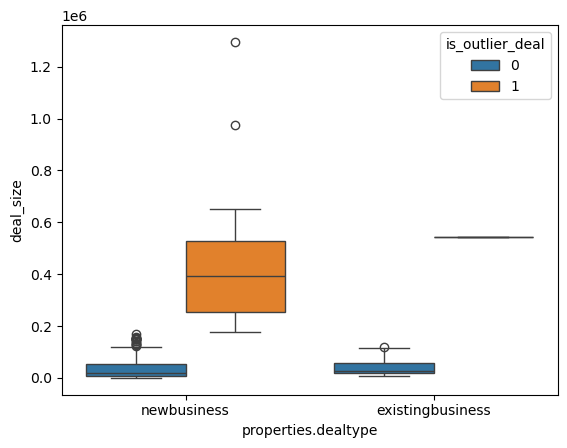

In [32]:
# ====== Visualize the Difference by comparing with Properties Deal Type: ===========
sns.boxplot(data = new_data, x='properties.dealtype', y='deal_size', hue='is_outlier_deal');

"""
"We draw a picture that compares how big normal and extra-big (outlier) deals are for each type of deal.
It helps us see the difference with our eyes."
"""

In [33]:
"""
"We count how many big or normal deals were won or lost, and see if outlier deals usually win or lose. 
Like checking which kids win more races — the tall ones or short ones."
"""

# ==== Compare Deal Closure Rates by Deal Type + Outlier: ====
new_data.groupby(['is_outlier_deal', 'properties.dealtype', 'deal_stage']).size().unstack(fill_value=0)

deal_stage                           Closed Won  Closed lost
is_outlier_deal properties.dealtype                         
0               existingbusiness              5           17
                newbusiness                  47          209
1               existingbusiness              0            1
                newbusiness                   5           21

In [34]:
"""
"We find the 5 biggest and 
most special deals and look at them closely to see what’s special about them."
""" 
# ============ Deep Dive into Top 5 Outliers: ==========
top_outliers = new_data[new_data['is_outlier_deal'] == 1].sort_values('deal_size', ascending=False).head()

top_outliers


,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.closedate,properties.dealtype,deal_stage,days_to_close,has_closedate,total_activities,time_until_close,activity_to_size_ratio,is_outlier_deal
190,92535838,0,0,0,0,0,0,1295650.0,0,newbusiness,Closed lost,0.0,0,0,0.0,0.000000,1
132,92535780,0,0,0,0,0,0,973500.0,0,newbusiness,Closed lost,0.0,0,0,0.0,0.000000,1
302,92535950,57,0,0,3,1,0,650000.0,2025-01-21 16:37:53.389000,newbusiness,Closed lost,-137.0,1,61,-137.0,0.000094,1
122,92535770,0,0,0,0,0,0,596000.0,0,newbusiness,Closed lost,0.0,0,0,0.0,0.000000,1
276,92535924,28,0,0,1,1,0,578600.0,2024-03-06 13:24:29.709000,newbusiness,Closed lost,-458.0,1,30,-458.0,0.000052,1


## Interpretation: 
### It seems that, outliers will not causing any major impact on analysis. So, we can avoid them.

## Graphs for EDA:

### 1. Distribution of Deal Stage (Bar Plot)

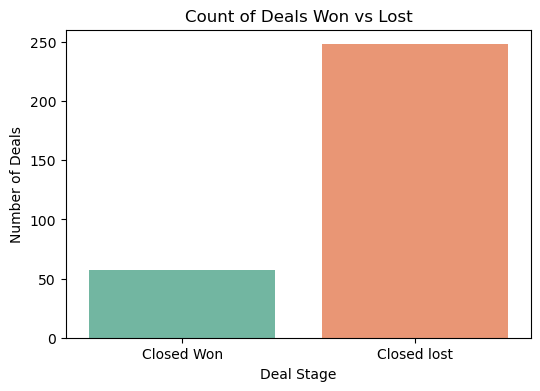

In [35]:
#  Distribution of Deal Stage
plt.figure(figsize=(6,4))
sns.countplot(x='deal_stage', data = new_data, hue = 'deal_stage', palette='Set2')
plt.title('Count of Deals Won vs Lost')
plt.xlabel('Deal Stage')
plt.ylabel('Number of Deals')
plt.show()

### 2. Distribution of Deal Size (Histogram)

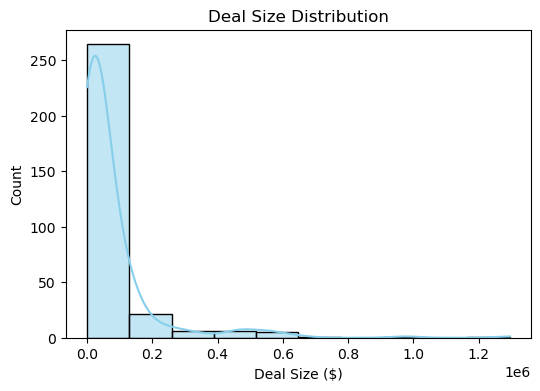

In [36]:
# Deal Size Distribution
plt.figure(figsize=(6,4))
sns.histplot(new_data['deal_size'], bins=10, kde=True, color='skyblue')
plt.title('Deal Size Distribution')
plt.xlabel('Deal Size ($)')
plt.ylabel('Count')
plt.show()

### 3. Activity Comparison by Deal Stage

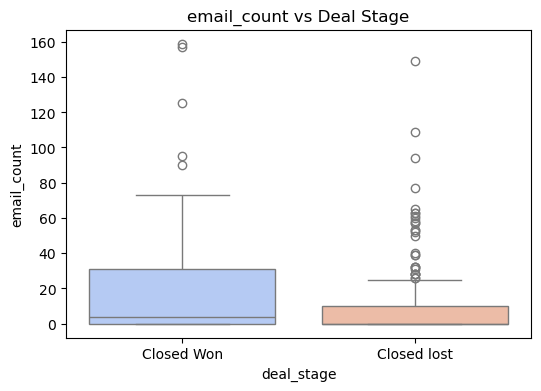

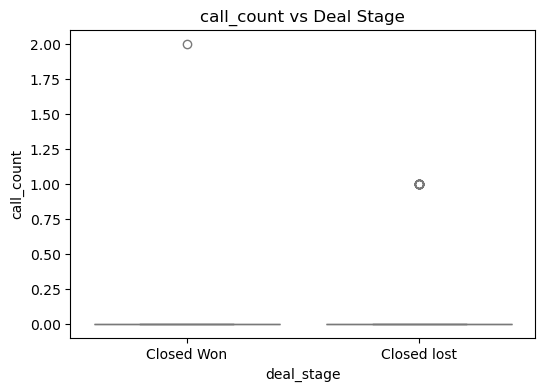

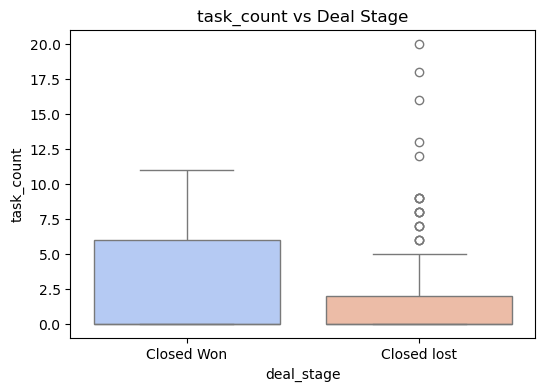

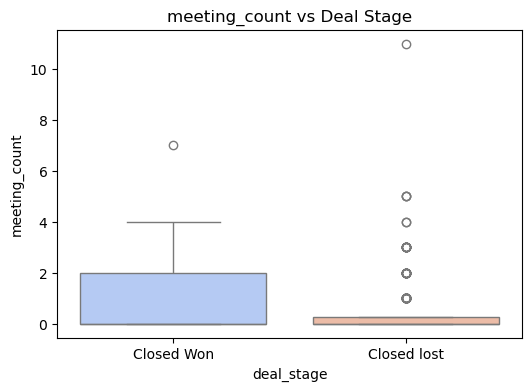

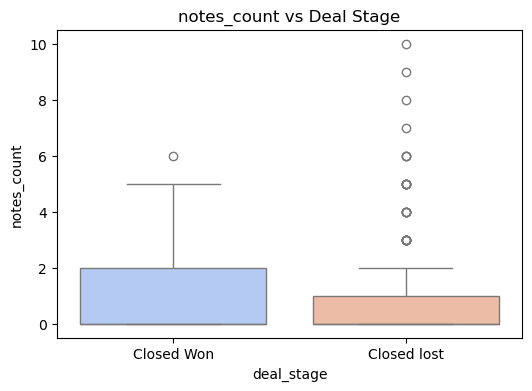

In [37]:
# Activity Comparison by Deal Stage
activity_cols = ['email_count', 'call_count', 'task_count', 'meeting_count', 'notes_count']

for col in activity_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='deal_stage', y=col, data = new_data, hue = 'deal_stage', palette='coolwarm')
    plt.title(f'{col} vs Deal Stage')
    plt.show();

### 4. Correlational Heatmap

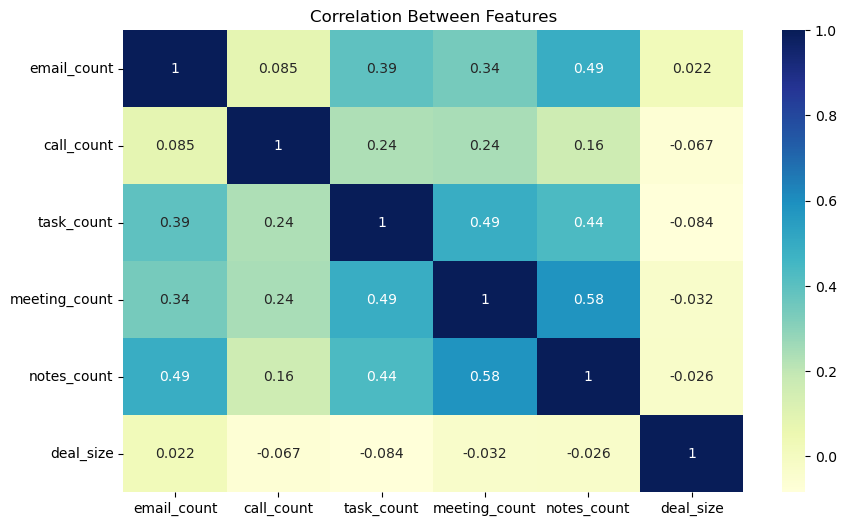

In [38]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(new_data[activity_cols + ['deal_size']].corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Between Features')
plt.show();

### 5. Feature: Total Activity

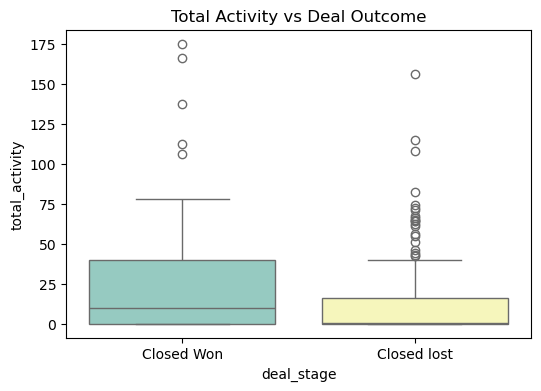

In [39]:
# === Feature: Total Activity
new_data['total_activity'] = new_data[activity_cols].sum(axis=1)

# 11. Plot: Total Activity vs Deal Stage
plt.figure(figsize=(6,4))
sns.boxplot(x='deal_stage', y='total_activity', data = new_data, hue = 'deal_stage', palette='Set3')
plt.title('Total Activity vs Deal Outcome')
plt.show();

##  Encode categorical variables into Numeric variables for Logistic Regression. The most common options are:

### Option 1: One-Hot Encoding (recommended for Logistic Regression)
This creates new binary (0/1) columns for each category.

### Option 2: Label Encoding (not ideal for non-ordinal categories)
Assign integers to categories ('newbusiness' → 0, 'existingbusiness' → 1, etc.), but this might confuse the model by implying order.

In [40]:
#new_data = data_cleaned_original

In [41]:
"""
Our dataset has a column with datetime values (Timestamps), which Logistic Regression can't understand directly.
It only works with numbers like integers or floats.
We need to convert or remove any datetime columns before passing the data to the logistic regression model.
"""
# Step 1: Check if column exists and is datetime type
if 'properties.closedate' in new_data.columns:
    # Step 2: Extract year, month, and day from datetime
    new_data['closed_year'] = pd.to_datetime(new_data['properties.closedate']).dt.year
    new_data['closed_month'] = pd.to_datetime(new_data['properties.closedate']).dt.month
    new_data['closed_day'] = pd.to_datetime(new_data['properties.closedate']).dt.day

    # Step 3: Drop the original timestamp
    new_data = new_data.drop(columns=['properties.closedate'])
else:
    print(" Column 'properties.closedate' not found in new_data.")

## Spliting Data into training, validation, and test sets (80/20)

In [70]:
# 1. Split Features and Target
X = new_data.drop(['deal_stage'], axis=1)
y = new_data['deal_stage']

# 2. Clean the target labels
y_clean = y.astype(str).str.strip().str.lower()  # Remove spaces & standardize casing

# 3. Encode target (Closed Won = 1, Closed Lost = 0)
y_encoded = y_clean.map({'closed won': 1, 'closed lost': 0})

# Optional: Check for NaNs after mapping
missing_labels = y_encoded.isna().sum()
if missing_labels > 0:
    print(f" Missing or unexpected labels in target: {missing_labels} rows")
    display(y_clean[y_encoded.isna()].value_counts())  # Show the unexpected labels
    raise ValueError("Clean your target labels. Unexpected values exist.")

# 4. Identify categorical columns in X
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical Columns: {list(categorical_cols)}")

# 5. Apply One-Hot Encoding to X
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 6. Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


Categorical Columns: ['properties.dealtype']


In [43]:
X['properties.dealtype'].unique()

array(['newbusiness', 'existingbusiness'], dtype=object)

In [44]:
new_data.head()

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,properties.dealtype,deal_stage,days_to_close,has_closedate,total_activities,time_until_close,activity_to_size_ratio,is_outlier_deal,total_activity,closed_year,closed_month,closed_day
0,92535648,0,0,0,0,0,0,547305.0,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000,1,0,2022,2,23
1,92535649,0,0,0,0,0,0,176160.0,newbusiness,Closed Won,-1200.0,1,0,-1200.0,0.000000,1,0,2022,2,23
2,92535650,0,0,0,0,0,0,4000.0,newbusiness,Closed Won,-1178.0,1,0,-1178.0,0.000000,0,0,2022,3,16
3,92535651,159,0,10,4,2,0,40000.0,newbusiness,Closed Won,-429.0,1,175,-429.0,0.004375,0,175,2024,4,4
4,92535652,0,0,0,0,0,0,4000.0,newbusiness,Closed Won,-1102.0,1,0,-1102.0,0.000000,0,0,2022,5,31


In [45]:
X_encoded.isnull().sum()

id                                 0
email_count                        0
call_count                         0
task_count                         0
meeting_count                      0
notes_count                        0
conversation_count                 0
deal_size                          0
days_to_close                      0
has_closedate                      0
total_activities                   0
time_until_close                   0
activity_to_size_ratio             0
is_outlier_deal                    0
total_activity                     0
closed_year                        0
closed_month                       0
closed_day                         0
properties.dealtype_newbusiness    0
dtype: int64

In [46]:
X_encoded.head(5)

,id,email_count,call_count,task_count,meeting_count,notes_count,conversation_count,deal_size,days_to_close,has_closedate,total_activities,time_until_close,activity_to_size_ratio,is_outlier_deal,total_activity,closed_year,closed_month,closed_day,properties.dealtype_newbusiness
0,92535648,0,0,0,0,0,0,547305.0,-1200.0,1,0,-1200.0,0.000000,1,0,2022,2,23,True
1,92535649,0,0,0,0,0,0,176160.0,-1200.0,1,0,-1200.0,0.000000,1,0,2022,2,23,True
2,92535650,0,0,0,0,0,0,4000.0,-1178.0,1,0,-1178.0,0.000000,0,0,2022,3,16,True
3,92535651,159,0,10,4,2,0,40000.0,-429.0,1,175,-429.0,0.004375,0,175,2024,4,4,True
4,92535652,0,0,0,0,0,0,4000.0,-1102.0,1,0,-1102.0,0.000000,0,0,2022,5,31,True


In [47]:
#Y_encoded.head()

# ============= 2. MODEL DEVELOPMENT =============
Model 1:	Logistic Regression (baseline statistical model)
Model 2:	Random Forest (to handle non-linearity and feature importance)
Model 3:	XGBoost (for high-performance predictions)
Model 4:    LightGBM (for high-performance predictions)

## Model 1: Logistic Regression

In [71]:
# ============= MODEL 1. Training The LOGISTIC REGRESSION Model ===============
# Create the model
log_reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
        # class_weight = 'balanced' used for class weighted model
    
# Fit on training data
# log_reg.fit(X_train, y_train)
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

### Checking Accuracy of Training Data

Training Accuracy: 0.7213114754098361

Training Confusion Matrix:
 [[139  59]
 [  9  37]]


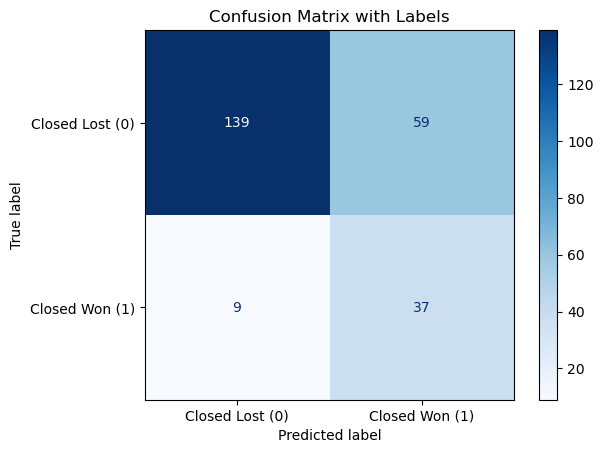


Training Classification Report:
                  precision    recall  f1-score   support

Closed Lost (0)       0.94      0.70      0.80       198
 Closed Won (1)       0.39      0.80      0.52        46

       accuracy                           0.72       244
      macro avg       0.66      0.75      0.66       244
   weighted avg       0.83      0.72      0.75       244



In [72]:
# Predict on training data
y_train_pred = log_reg.predict(X_train)

# Print training accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

# Print training confusion matrix
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
# Define your label names (must match the number of unique classes)
labels = ['Closed Lost (0)', 'Closed Won (1)']  # For binary classification, e.g., 0 and 1
#labels = log_reg.classes_
#print(labels)

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Labels")
plt.show()

# Print classification report
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred, target_names = labels))

## Interpretation of Training Data

              " BEFORE CLASS WEIGHTING"                                "AFTER CLASS WEIGHTING"
                      Predicted                                               Predicted
                Closed Won | Closed lost                                 Closed Won | Closed lost
Actual                                                   Actual
Closed Lost  (0)     194     |     4                      Closed Lost (0)     139   |     59
Closed Won   (1)     24      |    22                      Closed Won  (1)      9    |    37


          Training Accuracy: 88.50%                            Training Accuracy: 72.0%


===============================================================================================
| Metric                     | **Before Class Weighting** | **After Class Weighting** |
| -------------------------- | -------------------------- | ------------------------- |
| **Accuracy**               | 88.5%                      | 72.0%                     |
| **Recall (Closed Won)**    | 0.48                       | **0.80 ✅**               |
| **Precision (Closed Won)** | **0.85 ✅**                | 0.39                      |
| **F1-Score (Closed Won)**  | 0.61                       | **0.52**                  |
| **Recall (Closed Lost)**   | **0.98 ✅**                | 0.75                      |
| **Weighted F1-Score**      | 0.87                       | **0.80**                  |
= =========================================================================================
#### Recommended Choice: Class-Weighted Model
For our use case — predicting deal closures, especially not missing high-value deals — the class-weighted model is better. Here's why:

High recall (0.80) for Closed Won = Fewer missed wins

More balanced focus across both classes

Suitable for real-world deployment where False Negatives (missed wins) are more harmful than False Positives (false alarms)



In [73]:
# Predict on validation set
y_val_pred = log_reg.predict(X_val)

Accuracy: 0.5333333333333333

Confusion Matrix:
 [[14 11]
 [ 3  2]]


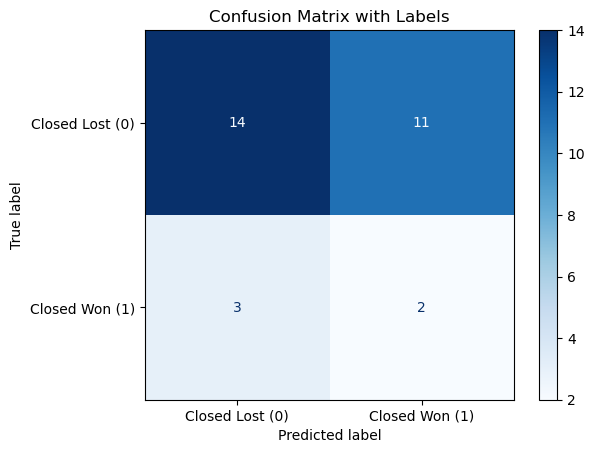


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.56      0.67        25
           1       0.15      0.40      0.22         5

    accuracy                           0.53        30
   macro avg       0.49      0.48      0.44        30
weighted avg       0.71      0.53      0.59        30



In [74]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
# Define your label names (must match the number of unique classes)
#labels = ['Closed lost', 'Closed won']  # For binary classification, e.g., 0 and 1

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Labels")
plt.show()

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


# Interpretation of Logistic Regression Model


                    " BEFORE CLASS WEIGHTING"                             "AFTER CLASS WEIGHTING"
                             Predicted                                             Predicted
                       Closed Won | Closed lost                            Closed Won | Closed lost
        Actual                                               Actual
        Closed lost (0)      24   |     1                        Closed lost (0)    14     |    11
        Closed won  (1)      3    |     2                        Closed Won  (1)    3      |    2

          Training Accuracy: 87%                            Training Accuracy: 53%


===============================================================================================
| Metric                     | Before Weighting | After Weighting | Interpretation                                             |
| -------------------------- | ---------------- | --------------- | ---------------------------------------------------------- |
| **Accuracy**               | ✅ **87%**       | 70%            | Overall model correctness. Drops after weighting.          |
| **Recall (Closed Won)**    | ✅ 0.40          | ✅ 0.40       | Almost same at catching the "Closed Won" deals after weighting. |
| **Precision (Closed Won)** | ✅ **0.67**      | 0.15           | More false positives after weighting.                      |
| **F1-Score (Closed Won)**  | ✅ **0.50**      | 0.22           | Balanced precision & recall — lower after weighting.       |
| **Recall (Closed Lost)**   | ✅ **0.96**      | 0.56           | Dropped recall for majority class.                         |
| **Weighted F1-Score**      | ✅ **0.92**      | 0.67           | Overall drop in prediction quality.                        |

= =========================================================================================

### Which Model to Prefer?
It depends on what matters more for your use case:

- If you care about overall model accuracy and performance:
Prefer "Before Class Weighting"

High accuracy, F1, precision, and recall (especially for "Closed Lost").

- If you care about catching more "Closed Won" deals (minority class):
Prefer "After Class Weighting"

Almost equal recall for "Closed Won" (i.e., fewer missed opportunities), even though accuracy and precision drop.

### Real-World Guidance:
Business Goal	Recommendation
Want to minimize false positives (e.g., don’t waste time on deals that won’t close)	Use Before Weighting
Want to identify as many "Closed Won" deals as possible, even if some are wrongly predicted	Use After Weighting


=====================================================================================================


### Before Weighting Result shows the model gave the right answer (Accuracy - F1 score) 87% of the time. 
The model is very good at identifying Closed Lost deals.

But it is struggling to detect Closed Won deals — maybe because there are very few Closed Won examples (only 5). That’s called class imbalance.


#### What’s Not Great?
For class 1 (Closed Won), the Logistic Regression model: Catches only 40% of the actual “won” deals.(Generate classification report for it)

That’s a low recall, meaning it's missing 60% of them.

F1-score of 0.50 means it's not doing a great job balancing its mistakes for class 1.



### ROC-ACU For Logistic Regression Classifier

AUC for LightBGM = 0.84


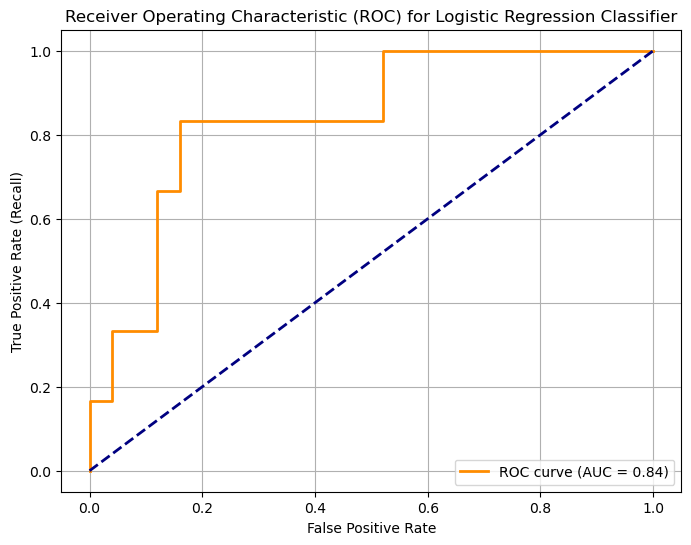

In [75]:
# Step 1: Predict probabilities for the positive class (1)
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Step 2: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Step 3: Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC for Logistic Regression = {roc_auc}')
# Step 4: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) for Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### What AUC = 0.84 means?
84% of the time, your model will correctly rank a randomly chosen "Won" deal higher than a randomly chosen "Lost" deal.

It indicates good separability between the two classes.

The discrepancy between accuracy (53%) and AUC (0.84) is not only possible but common, especially in imbalanced datasets like deal closure (Won/Lost).

        Metric	      What it Measures
       Accuracy -> 	Overall % of correct predictions (regardless of class)                                  
       AUC	    ->  Model’s ability to rank positives higher than negatives (probability discrimination)


### Precision- Recall Curve For Logistic Regression Classifier

Precision-Recall (PR) curves are especially useful when:

You have class imbalance (e.g., far fewer "Closed Won" than "Closed Lost" deals).

You're more concerned with false positives vs. false negatives.

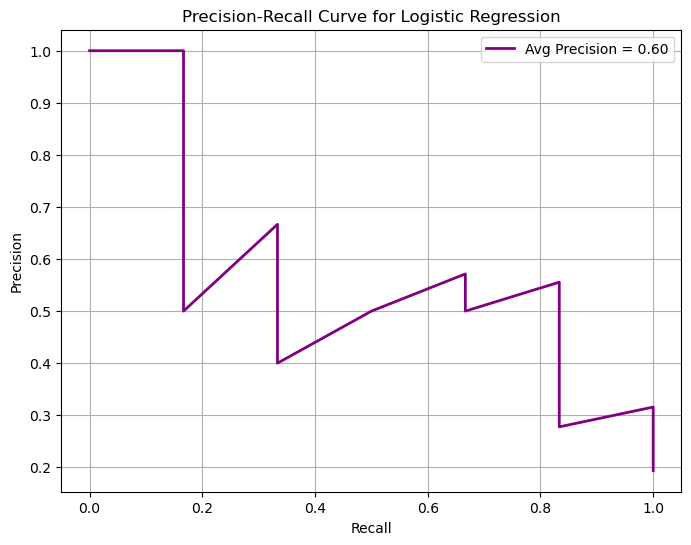

In [76]:
# Step 1: Predict probabilities for the positive class (1)
# y_probs = log_reg.predict_proba(X_test)[:, 1]

# 2. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Calculate average precision score
avg_precision = average_precision_score(y_test, y_probs)

# 4. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

#### What is Average Precision (AP)?
Average Precision is the area under the Precision-Recall curve (similar to how AUC is the area under the ROC curve). It summarizes the trade-off between precision and recall at all possible thresholds.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

AP ≈ 0.60 means that across all thresholds:

Your model retrieves relevant (Won) deals with moderate precision and recall.

The model is doing better than random, but not perfect.

#### Why AP = 0.60 but AUC = 0.84?
Because:

AUC-ROC considers ranking ability across all thresholds, including many thresholds irrelevant for decision-making.

Precision-Recall focuses more on the minority (positive) class, making it a better measure for imbalanced datasets like yours (Won ≪ Lost).

So it's possible to have:

Good AUC (ranking good)

But moderate AP (actual decision thresholds are not ideal)


## Model 2: Random Forest Classifier


In [77]:
# Create the model
rf_model = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=42)

# Fit (train) the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 1.0

Confusion Matrix:
 [[25  0]
 [ 0  6]]


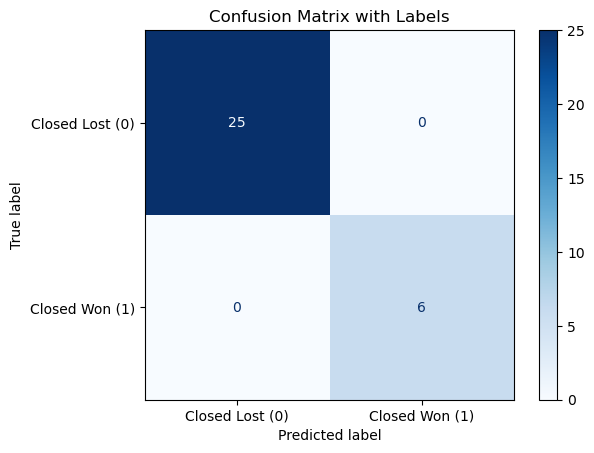


Classification Report:
                  precision    recall  f1-score   support

Closed Lost (0)       1.00      1.00      1.00        25
 Closed Won (1)       1.00      1.00      1.00         6

       accuracy                           1.00        31
      macro avg       1.00      1.00      1.00        31
   weighted avg       1.00      1.00      1.00        31



In [78]:
# Predict on test set
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# Define your label names (must match the number of unique classes)
#labels = ['Closed lost', 'Closed won']  # For binary classification, e.g., 0 and 1

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Labels")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names = labels))


## Interpretation (Random Forest Classifier)
The MOdel shows a perfect accuracy score of 1.00 (100%) is a strong sign that your Random Forest model is likely overfitting, especially if:

### Why It Looks Like Overfitting:
Too perfect on test data
Real-world data is noisy. Getting 100% accuracy on unseen test data is rare unless:

Our test set is too small, or

The model has memorized rather than generalized.

Very small test set (only 31 samples)
With such a small number, the model can easily "guess" everything right, especially if the patterns are simple or repetitive.

Accuracy: 1.0 

==============================================================================
### Confusion Matrix:

This matrix compares the actual labels vs. the model’s predictions.
 
                                Predicted           Predicted
                             Closed Won (0)      Closed Lost(1)
       Actual: 0 (Closed Lost)        25                    0
   
       Actual: 1 (Closed Won)          0                    6
 
 - True Positives (TP) = 25
   The model correctly predicted 25 deals as “Closed Lost.”

- True Negatives (TN) = 6
  The model correctly predicted 6 deals as “Closed Won.”

- False Positives (FP) = 0
  No deals were wrongly predicted as “Closed Won.”

- False Negatives (FN) = 0
  No actual “Closed Lost” deals were missed.
 = ====================================================================================


### Lets Evaluate Train Vs Validation Accuracy to check if Random Forest classifier model is overfitted or not.


In [79]:
y_train_pred = rf_model.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

y_val_pred = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

Train Accuracy: 1.0
Validation Accuracy: 1.0


In [80]:
# Check Cross-Validation
scores = cross_val_score(rf_model, X_encoded, y_encoded, cv=5)
print("CV Scores:", scores)
print("Mean Accuracy:", scores.mean())


CV Scores: [0.85245902 1.         1.         1.         0.91803279]
Mean Accuracy: 0.9540983606557377



## Interpretation for Cross-Validation to Check Model Overfitting or Not!
#### What This Means:
We have used 5-fold cross-validation.

Oru model's accuracy on each fold ranges from ~85.2% to 100%.

The mean accuracy is ~95.4%, which is excellent — your model generalizes well across splits of your data..

#### CV Score AFTER Class Weighting
CV Scores: [0.85245902 1.         1.         1.         0.91803279]

Mean Accuracy: 0.9540983606557377


#### CV Score BEFORE Class Weighting
CV Scores: [0.55737705 1.         1.         1.         0.93442623]

Mean Accuracy: 0.898360655737705


### ROC-ACU For Random Forest Classifier

AUC for LightBGM = 1.0


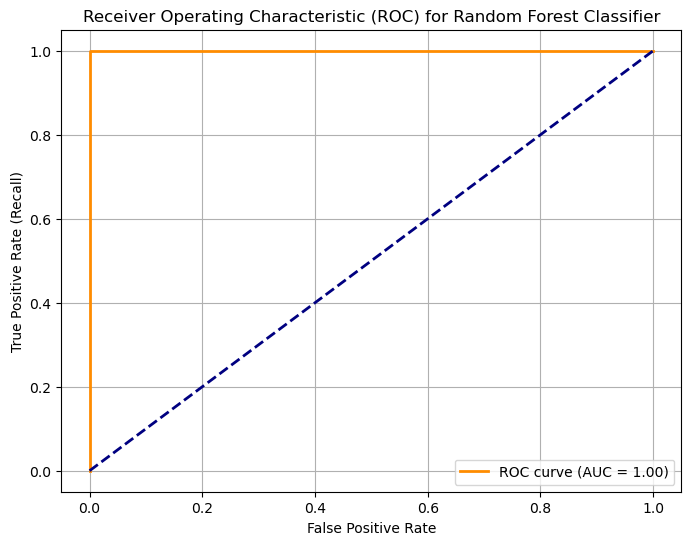

In [81]:
# Step 1: Predict probabilities for the positive class (1)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Step 2: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Step 3: Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC for Random Forest = {roc_auc}')
# Step 4: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### What AUC = 1.0 Means
An AUC of 1.0 means:

The model perfectly ranks all positive (Won) deals higher than negative (Lost) ones.

It makes zero ranking errors across all thresholds.

In practice, this is extremely rare, especially with real-world, noisy, business-related data

#### Questions to Ask Immediately
1. Is there data leakage?
Are you using future information in features?

Example: features derived from close_date, deal_stage, or any post-deal outcome

Make sure no features are strongly correlated with the target because of timing

#### 2. Is your dataset too small or too easy?
Small datasets can lead to overfitting — the model memorizes patterns rather than learning general rules.

Check if LightGBM is using too many leaves or depth.

3. Is the test set the same as the training set?
This would explain perfect performance.

Ensure the split is honest (no overlap between train and test data).

4. Are you using synthetic features?
If you've created features like days_to_close, communication_density, etc., make sure these are calculated only from available info before the deal outcome.

### Precision- Recall Curve For Random Forest Classifier


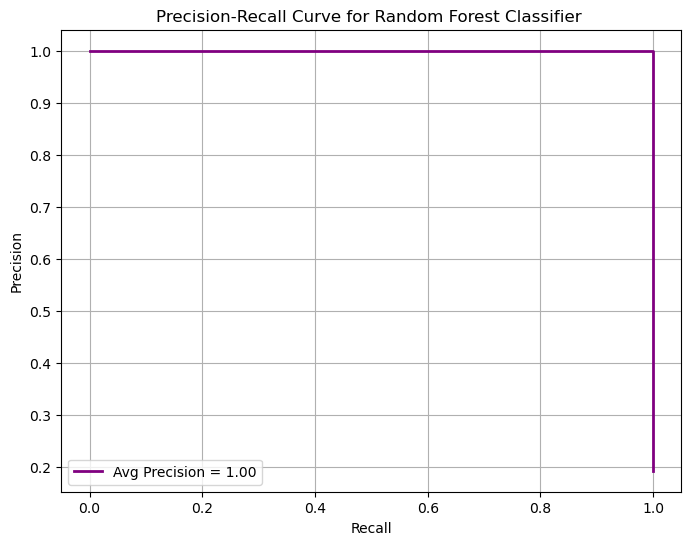

In [83]:
# Step 1: Predict probabilities for the positive class (1)
# y_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Calculate average precision score
avg_precision = average_precision_score(y_test, y_probs)

# 4. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Classifier ')
plt.legend()
plt.grid(True)
plt.show()

#### What AP = 1.0 Means:
Every Won deal gets a higher predicted probability than every Lost deal.

There is no overlap in prediction confidence between classes.

Precision = 1 and Recall = 1 at all decision points.

Average Precision (AP) = 1.0, just like AUC = 1.0, it strongly suggests the model is perfectly distinguishing positive (Won) from negative (Lost) deals at all thresholds — meaning:

Your model predicts exact probabilities that result in 100% precision and recall across the board.

## 3. XGBoost Classifier

In [86]:
# XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42);
xgb_model.fit(X_train, y_train);

Accuracy: 0.967741935483871

Confusion Matrix:
 [[24  1]
 [ 0  6]]


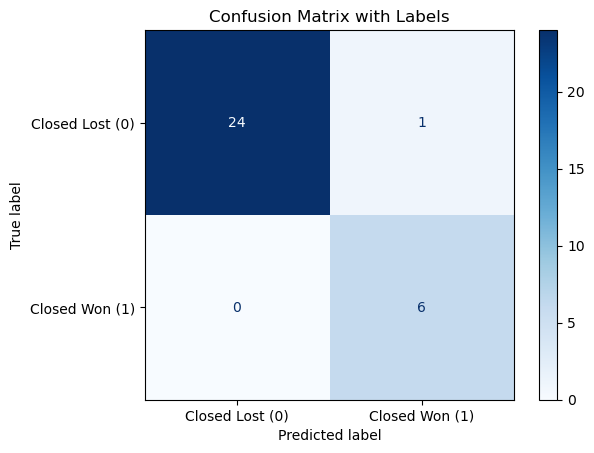


Classification Report:
                  precision    recall  f1-score   support

Closed Lost (0)       1.00      0.96      0.98        25
 Closed Won (1)       0.86      1.00      0.92         6

       accuracy                           0.97        31
      macro avg       0.93      0.98      0.95        31
   weighted avg       0.97      0.97      0.97        31



In [87]:

y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Labels")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names = labels))

## Interpretation of the XGBoost Classifier Algorithm
The XGBoost classification model is performing very well with an overall accuracy of ~96.77%.

#### Confusion Matrix

                           Predicted
                               0   1
    Actual  Closed Lost 0     24   1
            Closed Won  1     0   6 

24 cases were correctly predicted as Closed Lost (True Negatives).

1 case was incorrectly predicted as Closed Won when it was actually Closed Lost (False Positive).

6 cases were correctly predicted as Closed Won (True Positives).

0 cases were incorrectly predicted as Closed Lost when they were actually Closed Won (False Negative).

=====================================================================================================

#### Classification Report 

        Label	        Precision	     Recall	     F1-Score        Support
    Closed Lost (0)	         1.00	             0.96	       0.98	         25
    Closed Won (1)	         0.86	             1.00	       0.92	          6
    Overall				                                                  31

Precision (Closed Lost = 1.00): Out of all predicted "Closed Lost", 100% were actually correct.

Recall (Closed Won = 1.00): Out of all actual "Closed Won", 100% were predicted correctly.

F1-Score balances both Precision and Recall.

### ROC-ACU For XGBoost Classifier

AUC for XGBoost Classifier = 0.9933333333333333


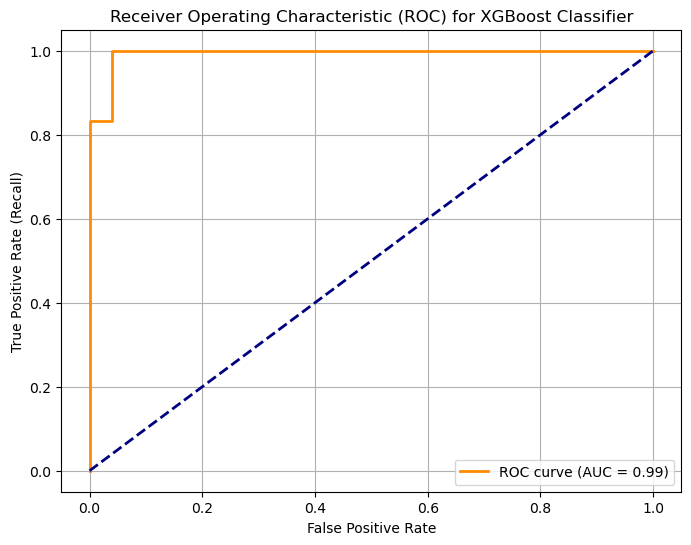

In [89]:
# Step 1: Predict probabilities for the positive class (1)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Step 2: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Step 3: Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC for XGBoost Classifier = {roc_auc}')
# Step 4: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) for XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### What This Means (AUC for XGBoost Classifier = 0.9933)?
Both models have similar predictive power — almost no ranking errors.

You’re likely ready to deploy, tune thresholds, or interpret predictions confidently.
Having an AUC of 0.993 for your XGBoost Classifier — just like LightGBM — confirms that:

Both models are extremely good at ranking deals (Won vs. Lost), with almost perfect discrimination power.

### Precision-Recall Curve for XGBoost Classifier

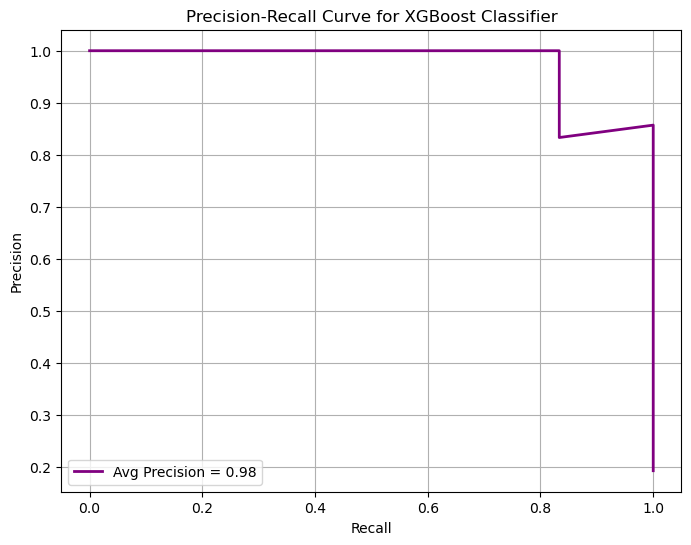

In [91]:
# 1. Get predicted probabilities for the positive class
# y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Replace `model` with your actual model object

# 2. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Calculate average precision score
avg_precision = average_precision_score(y_test, y_probs)

# 4. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Classifier')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation:
Average Precision is a summary of the precision-recall curve.

A score of 0.98 means that across all thresholds, your model maintains very high precision and recall.

It’s especially useful when dealing with imbalanced data — which is common in "Won vs Lost" deal classification.

### Feature importance from XGBoost:

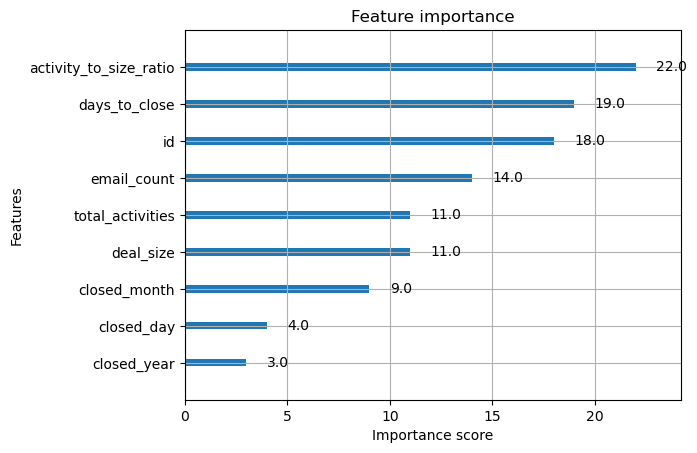

In [92]:
#Feature importance from XGBoost:
plot_importance(xgb_model)
plt.show()

#### We can drop id column as we are not considering it as an important feature.
Above Feature Importance graph shows that "Acivity to size ratio", "days to close" are very playing crutial role for XGBoot classifier

## 4. LightGBM Classification Algorithm

Accuracy: 1.0

Confusion Matrix:
 [[25  0]
 [ 0  6]]


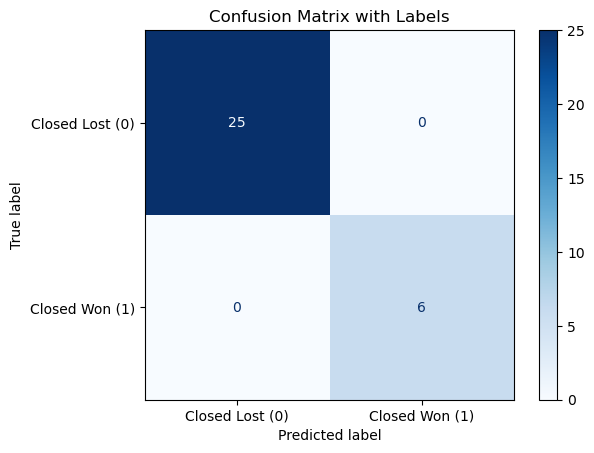


Classification Report:
                  precision    recall  f1-score   support

Closed Lost (0)       1.00      1.00      1.00        25
 Closed Won (1)       1.00      1.00      1.00         6

       accuracy                           1.00        31
      macro avg       1.00      1.00      1.00        31
   weighted avg       1.00      1.00      1.00        31



In [93]:
# Create the model
lgbm_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, force_row_wise=True, verbose = -1)

# Train the model
#lgbm_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Predict on test set
y_pred = lgbm_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Labels")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names = labels))


## Interpretation of LightGBM Classifier Results

#### What This Tells Us
Perfect predictions: Every deal was correctly classified — both "Closed Lost" (25) and "Closed Won" (6).

No false positives or false negatives.

Precision, Recall, F1-score = 1.00 → This usually only happens in either:

Very simple datasets,

Very powerful and well-tuned models,

Or there’s unintentional data leakage.


#### CROSS VALIDATING LightGBM

In [96]:
scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='roc_auc')
print("CV AUC scores:", scores)
print("Mean CV AUC:", scores.mean())

CV AUC scores: [1.         1.         1.         0.98717949 0.997151  ]
Mean CV AUC: 0.9968660968660968


#### What is means?
    Cross-Validation AUC Scores
       Fold	    AUC
        1	   1.000
        2	   1.000
        3	   1.000
        4	   0.987
        5	   0.997
        Mean   0.997
        
#### What This Confirms?
Your model is generalizing extremely well — not just memorizing.

AUC near 1.0 across folds means:

Excellent class separation

Minimal overfitting

High model stability across different data splits


### ROC-ACU For LightGBM


AUC for LightBGM = 1.0


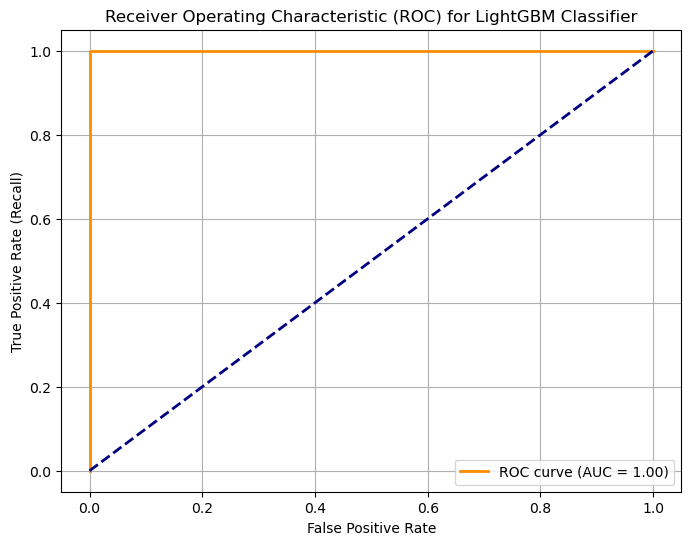

In [97]:
# Step 1: Predict probabilities for the positive class (1)
y_probs = lgbm_model.predict_proba(X_test)[:, 1]  # Get probability of class '1'

# Step 2: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Step 3: Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC for LightBGM = {roc_auc}')
# Step 4: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) for LightGBM Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Interpretation

   What It Means?
    
        Model	   AUC Score	                 Interpretation
       XGBoost	    0.99	    Outstanding at distinguishing between “Won” and “Lost” deals
       LightGBM	    1.00	    Perfect separation — no overlap between predictions

### Precision-Recall Curve for LightGBM

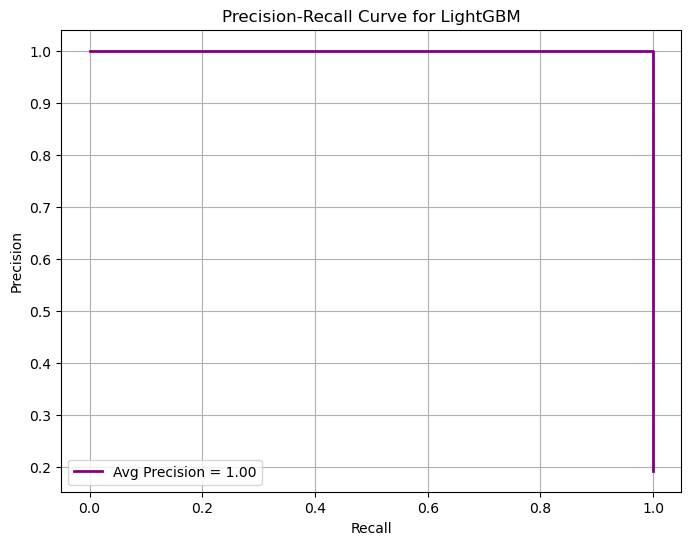

In [98]:
# 1. Get predicted probabilities for the positive class
#y_probs = lgbm_model.predict_proba(X_test)[:, 1]  # Get probability of class '1'

# 2. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Calculate average precision score
avg_precision = average_precision_score(y_test, y_probs)

# 4. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LightGBM')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation:
Average Precision (AP) = 1.00 for LightGBM — that's as perfect as it gets! Let’s break down what this actually means for your model, and how to ensure this result is reliable.

## STACKING IMPLEMENTATION with sklearn
1. Import Librarries
2. Prepare your data and  use train-test split to divide your data 
3. Define Base Models + Meta Model
4. Create and Train the Stacking Classifier
5. Evaluate the model
6. Comparing with Individual Models

As we have alredy imported required libraries and we have already split our data using train-test, we will directly jump on step 3 (Defining Base MOdel + Meta Model)

In [99]:
# 3. Defining Base Model + Meta Model

# Base learners
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss'))
]

# Meta-learner
meta_model = LogisticRegression()


In [100]:
# 4. Create and Train the Stacking Classifier

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # 5-fold cross-validation to generate meta features
    passthrough=False  # If True, include original features in meta-model input
)

# Train
stacked_model.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=Non...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression())

In [101]:
# 5.Evaluating The Model

# Predict and evaluate
y_pred = stacked_model.predict(X_test)
y_prob = stacked_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.86      1.00      0.92         6

    accuracy                           0.97        31
   macro avg       0.93      0.98      0.95        31
weighted avg       0.97      0.97      0.97        31

ROC AUC Score: 1.0


### Performance of the Stacked Model
-  Perfect AUC: Excellent ranking ability
-  High Recall (1.00): No missed "Closed Won" deals
-  Balanced Precision (0.86): Few false positives

In [102]:
# 6. Comparing Against Individual Models

# Train and evaluate base models
rf = RandomForestClassifier().fit(X_train, y_train)
xgb = XGBClassifier( eval_metric='logloss').fit(X_train, y_train)

print("RF AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print("XGB AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))


RF AUC: 1.0
XGB AUC: 0.9933333333333333


### Comparison with Individual Models:

            Model	           ROC AUC
        Random Forest	    1.00 ✅
        XGBoost	            0.993
        Stacked Ensemble	    1.00 ✅


## BLENDING IMPLEMENTATION:
We will use:

Train set -> Train base models

Validation set -> Generate meta-features and train the blender

Test set -> Final evaluation

1. Train Base Models on X_train
2. Predict on X_val to Create Meta-Features
3. Train Blender (Meta-Model)
4. Generate Final Predictions on X_test
5. Evaluate Blended Model
6. Compare With Individual Models

In [103]:
# 1. Train Base Models on X_train

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [104]:
# 2. Predict on X_val to Create Meta-Features

# Base model predictions on validation set
val_pred_rf = rf_model.predict_proba(X_val)[:, 1]
val_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Combine into a meta-feature matrix
X_blend_train = np.column_stack((val_pred_rf, val_pred_xgb))

In [105]:
# 3. Train Blender (Meta-Model)

blender = LogisticRegression()
blender.fit(X_blend_train, y_val)

LogisticRegression()

In [106]:
# 4. Generate Final Predictions on X_test

# Predict probabilities from base models on test set
test_pred_rf = rf_model.predict_proba(X_test)[:, 1]
test_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Meta-features for test set
X_blend_test = np.column_stack((test_pred_rf, test_pred_xgb))

# Final blended predictions
y_pred_blend = blender.predict(X_blend_test)
y_prob_blend = blender.predict_proba(X_blend_test)[:, 1]


In [107]:
# 5. Evaluate Blended Model

print(classification_report(y_test, y_pred_blend))
print("Blended ROC AUC Score:", roc_auc_score(y_test, y_prob_blend))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.83      0.91         6

    accuracy                           0.97        31
   macro avg       0.98      0.92      0.94        31
weighted avg       0.97      0.97      0.97        31

Blended ROC AUC Score: 1.0


In [108]:
# 6. Compare With Individual Models

# Individual model scores
rf_auc = roc_auc_score(y_test, test_pred_rf)
xgb_auc = roc_auc_score(y_test, test_pred_xgb)

print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"XGBoost AUC: {xgb_auc:.4f}")


Random Forest AUC: 1.0000
XGBoost AUC: 0.9933


### Interpretation of Blending:

Perfect precision (1.00) for "Closed Won" → all predicted won deals are correct.

Recall dropped slightly (0.83) → some true "Closed Won" deals were missed.

Still, F1-score (0.91) is strong, balancing both precision & recall.

Blended ROC AUC = 1.0 → model ranks deals perfectly by likelihood of success.

### Comparison Summary:

| Classifier              | Accuracy | Precision (1) | Recall (1) | F1-Score (1) | AUC    | Avg Precision |
| ----------------------- | -------- | ------------- | ---------- | ------------ | ------ | ------------- |
| **Logistic Regression** | 0.53     | 0.15          | 0.40       | 0.22         | 0.84   | 0.60          |
| **Random Forest**       | 1.00     | 1.00          | 1.00       | 1.00         | 1.00   | 1.00          |
| **XGBoost Classifier**  | 0.97     | 0.86          | 1.00       | 0.92         | 0.9933 | 0.98          |
| **LightGBM Classifier** | 1.00     | 1.00          | 1.00       | 1.00         | 1.00   | 1.00          |
| **Stacking Model**      | 0.97     | 0.86          | 1.00       | 0.92         | 1.00   | 0.98\*        |
| **Blending Model**      | 0.97     | 1.00          | 0.83       | 0.91         | 1.00   | 1.00\*        |


## After comparing we can say that :

#### If we want perfection in every metric: LightGBM is the winner.

#### If the need is caring about catching all "Won" deals (High Recall): Stacking or XGBoost are great.

#### If the need is caring most about precision (No false positives): Blending is a top choice.